In [5]:
!pip -q install jcopml
!pip -q install luwiji

In [6]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

from luwiji.logistic_regression import illustration

# Import Data

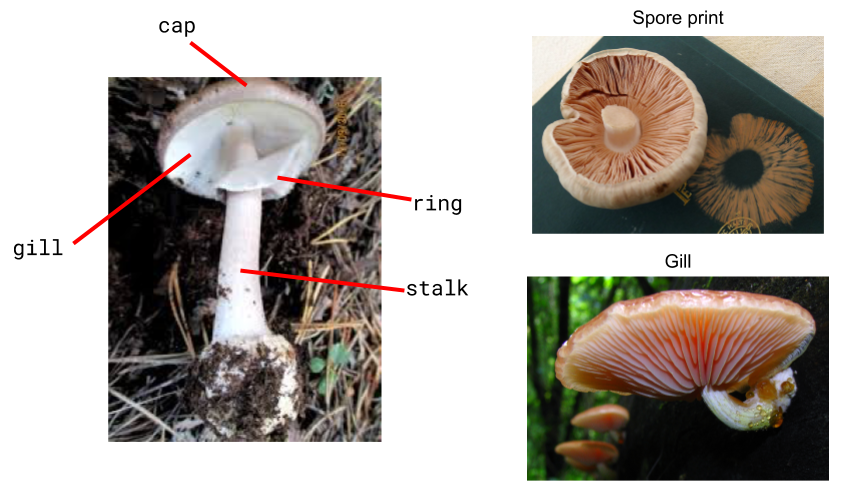

In [8]:
illustration.mushroom

In [7]:
df = pd.read_csv('/kaggle/input/mushrooms/mushrooms.csv')
df.head()

,edible,cap_shape,cap_surface,cap_color,bruises,odor,gill_attachment,gill_spacing,gill_size,gill_color,...,stalk_surface_below_ring,stalk_color_above_ring,stalk_color_below_ring,veil_type,veil_color,ring_number,ring_type,spore_print_color,population,habitat
0,False,convex,smooth,brown,True,pungent,free,close,narrow,black,...,smooth,white,white,partial,white,1,pendant,black,scattered,urban
1,True,convex,smooth,yellow,True,almond,free,close,broad,black,...,smooth,white,white,partial,white,1,pendant,brown,numerous,grasses
2,True,bell,smooth,white,True,anise,free,close,broad,brown,...,smooth,white,white,partial,white,1,pendant,brown,numerous,meadows
3,False,convex,scaly,white,True,pungent,free,close,narrow,brown,...,smooth,white,white,partial,white,1,pendant,black,scattered,urban
4,True,convex,smooth,gray,False,none,free,crowded,broad,black,...,smooth,white,white,partial,white,1,evanescent,brown,abundant,grasses


,missing_value,%
edible,0,0.00
cap_shape,0,0.00
cap_surface,0,0.00
cap_color,0,0.00
bruises,0,0.00
odor,0,0.00
gill_attachment,0,0.00
gill_spacing,0,0.00
gill_size,0,0.00
gill_color,0,0.00


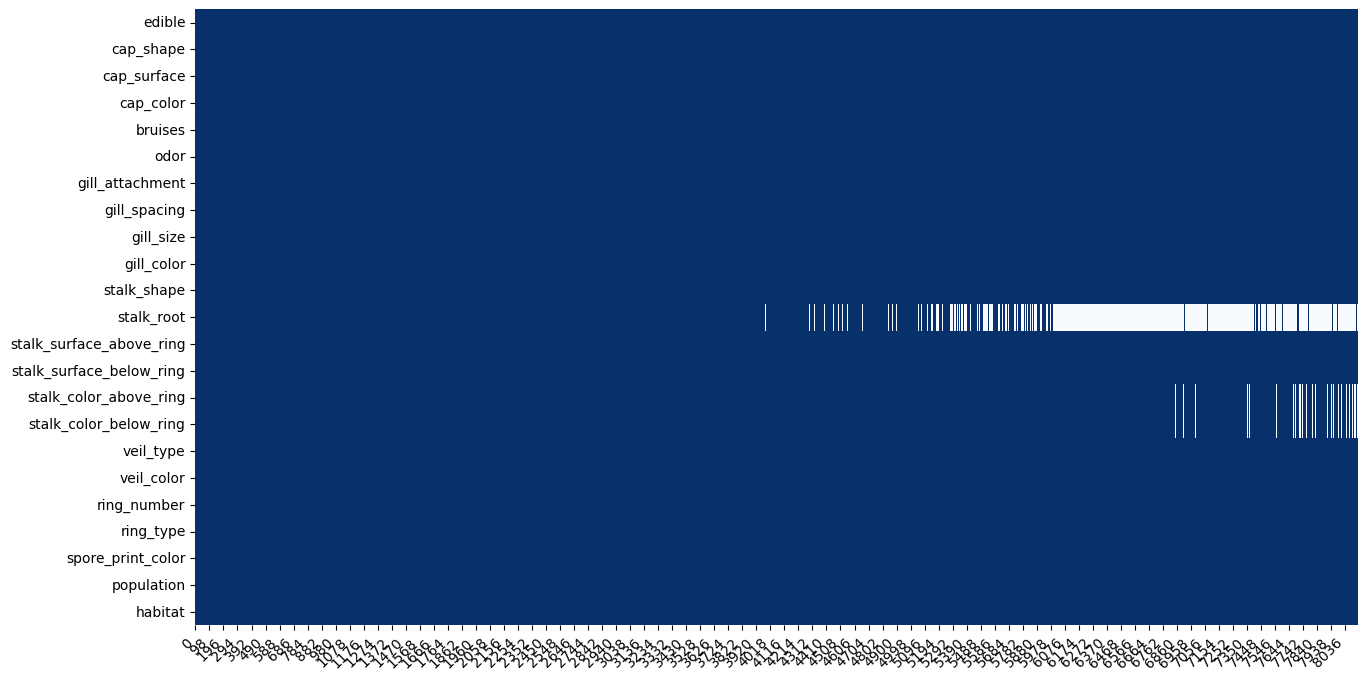

In [10]:
plot_missing_value(df, return_df=True)

<Axes: xlabel='edible', ylabel='count'>

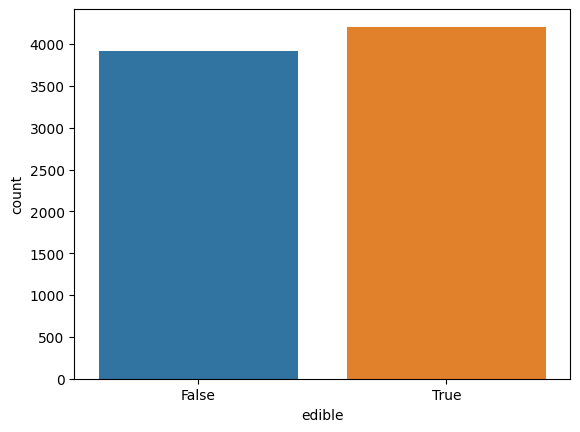

In [11]:
import seaborn as sns

sns.countplot(data=df, x='edible')

# Association Matrix -> for Categoric Data

In [12]:
from jcopml.plot import plot_association_matrix

In [13]:
df.dtypes

edible                        bool
cap_shape                   object
cap_surface                 object
cap_color                   object
bruises                       bool
odor                        object
gill_attachment             object
gill_spacing                object
gill_size                   object
gill_color                  object
stalk_shape                 object
stalk_root                  object
stalk_surface_above_ring    object
stalk_surface_below_ring    object
stalk_color_above_ring      object
stalk_color_below_ring      object
veil_type                   object
veil_color                  object
ring_number                  int64
ring_type                   object
spore_print_color           object
population                  object
habitat                     object
dtype: object

In [14]:
df.ring_number.value_counts() # bisa jadi numerik / kategorik

ring_number
1    7488
2     600
0      36
Name: count, dtype: int64

In [16]:
plot_association_matrix(df, target_col='edible', categoric_col='auto') # kita anggap semua feature categoric

ValueError: Categorical column should have at least 2 category
You should remove these column from your data -> veil_type

In [17]:
df.veil_type.value_counts()

veil_type
partial    8124
Name: count, dtype: int64

**veil_type** hanya `memiliki 1 kategori`, jadi lebih baik untuk di `drop`

In [19]:
df.drop(columns='veil_type', inplace=True)

**Cramer's V** - `Paling Umum digunakan`
- Paling terkenal
- Asosiasi antara dua feature kategorikal

**Proficiency U(X|Y)**
- Asosiasi satu arah X ke Y

**Proficiency U(X|Y)**
- Asosiasi satu arah Y ke X

**Symmetric Proficiency**
- Rata-rata dari Proficiency U(X|Y) dan Proficiency U(X|Y)

In [20]:
plot_association_matrix(df, target_col='edible', categoric_col='auto') # kita anggap semua feature categoric

interactive(children=(ToggleButtons(description='method', options=("Cramer's V", 'Proficiency U(X|Y)', 'Profic…

### Cara Kerja

**Feature Association** = Jika terdapat `dua feature` yang saling `berasosiasi kuat`, salah satu boleh di `buang`

**Target Association** = Jika terdapat feature yang `berasosiasi kuat` dengan `target`, maka feature tersebut `digunakan`

**Catatan:**

Kita bisa lihat dari `proficiency` bahwa `odor` sangat menentukan apakah suatu jamur edible atau tidak `U(X|Y) = 0.9`, tetapi bukan berarti sebaliknya `U(Y|X) = 0.4`

# Dataset Splitting

In [22]:
X = df[['odor', 'gill_color', 'ring_type', 'spore_print_color']]
y = df.edible

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train.shape, X_test.shape, X_train.shape, y_train.shape

((6499, 4), (1625, 4), (6499, 4), (6499,))

# Training

In [23]:
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp

In [28]:
# Preprocessor
preprocessor = ColumnTransformer([
    ('numeric', cat_pipe(encoder='onehot'), X_train.columns)
])

# Pipeline
lr_pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(multi_class='multinomial', penalty='l2', solver='lbfgs', n_jobs=-1, random_state=42))
])
    
# Parameter Tunning
model = GridSearchCV(lr_pipeline, gsp.logreg_params, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

# Evaluation
print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 14 candidates, totalling 42 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

{'algo__C': 10.0, 'algo__fit_intercept': True}
0.9938452069549162 0.9938453960417766 0.9975384615384615


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Evaluation

In [29]:
from jcopml.plot import plot_confusion_matrix, plot_classification_report, plot_roc_curve, plot_pr_curve

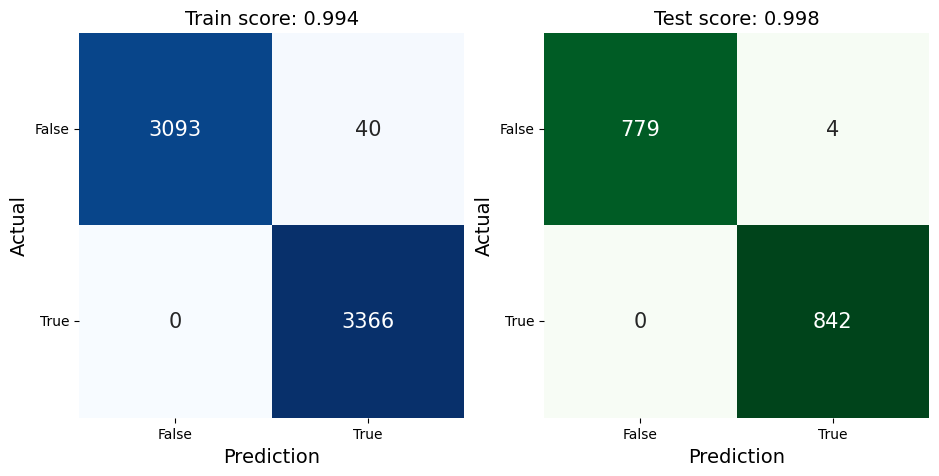

In [30]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, model)

In [31]:
plot_classification_report(X_train, y_train, X_test, y_test, model, report=True)

Train report
              precision    recall  f1-score   support

       False       1.00      0.99      0.99      3133
        True       0.99      1.00      0.99      3366

    accuracy                           0.99      6499
   macro avg       0.99      0.99      0.99      6499
weighted avg       0.99      0.99      0.99      6499


Test report
              precision    recall  f1-score   support

       False       1.00      0.99      1.00       783
        True       1.00      1.00      1.00       842

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625



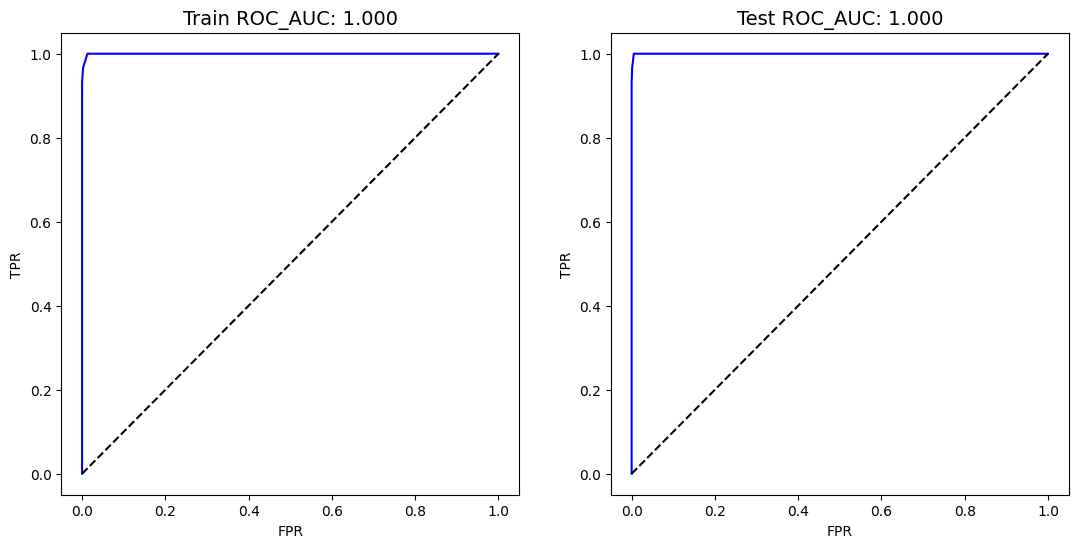

In [32]:
plot_roc_curve(X_train, y_train, X_test, y_test, model)

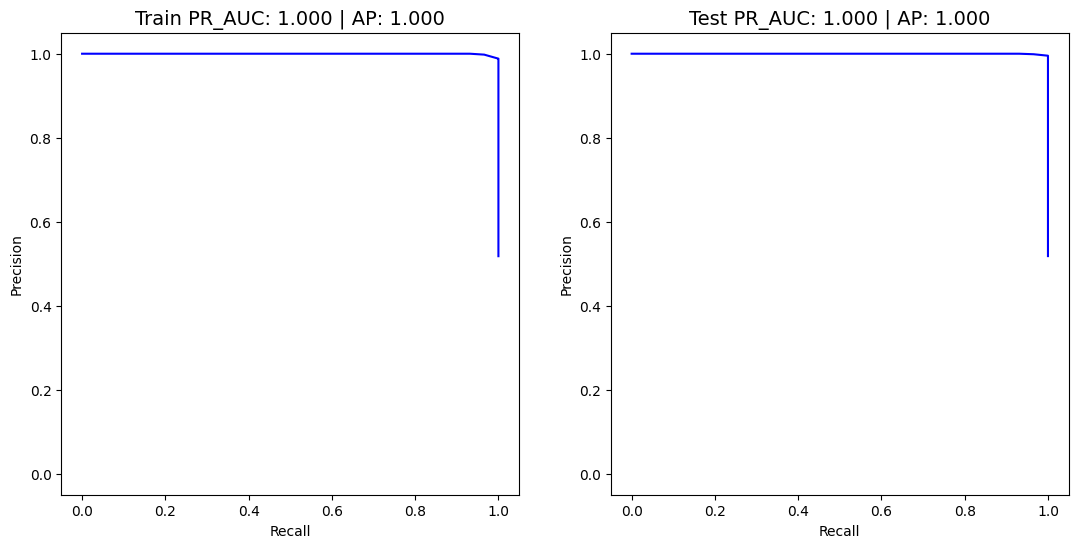

In [33]:
plot_pr_curve(X_train, y_train, X_test, y_test, model)

# Feature Importance (tambahan untuk mencari insight karena hasil score sangat bagus)

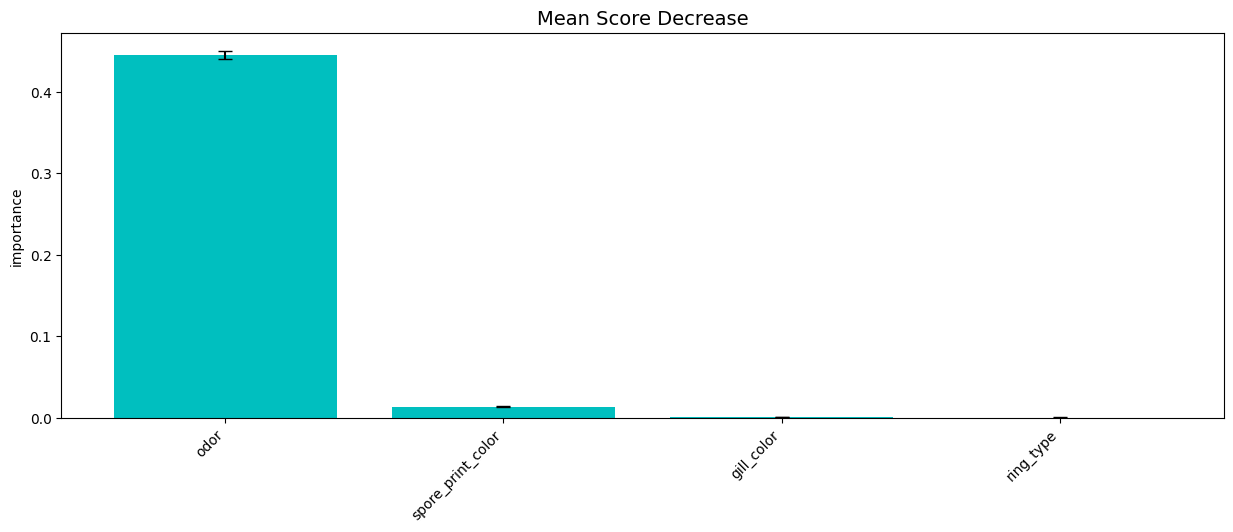

In [34]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

# Insight From Data

<Axes: xlabel='ring_type', ylabel='count'>

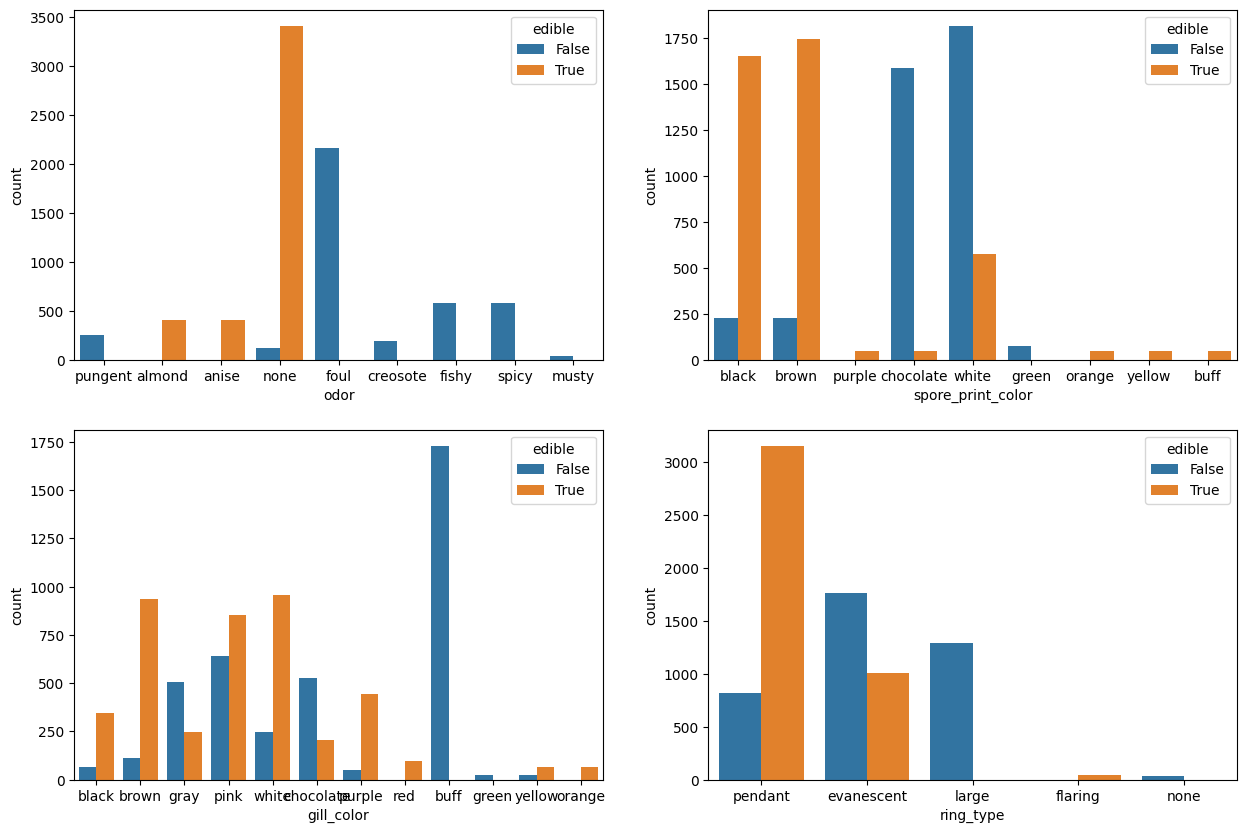

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))
plt.subplot(221)
sns.countplot(data=df, x='odor', hue='edible')
plt.subplot(222)
sns.countplot(data=df, x='spore_print_color', hue='edible')
plt.subplot(223)
sns.countplot(data=df, x='gill_color', hue='edible')
plt.subplot(224)
sns.countplot(data=df, x='ring_type', hue='edible')

# Correlation Ratio (Optional) - Jarang Digunakan

Digunakan untuk `Numerik vs Kategorik` dan `Kategorik vs Numerik`

In [43]:
from jcopml.plot import plot_correlation_ratio

In [57]:
# plot_correlation_ratio(df, ['cap_shape', 'odor'], ['ring_number'])